# Defensive Asset Allocation with momentum
## Use Index of representative asset classes
#### Market Index ETF, sector etf, bond etf are included
#### Result is driven from 2010 to 2021 market data


In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import pandas as pd
import numpy as np

from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import momentum_rebalance_strategy

%matplotlib inline
from matplotlib import pyplot as plt

import quantstats

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [16]:
asset_class_ticker =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "QQQ",  # Invesco QQQ trust Nasdaq 100                          1999-03-10
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
    "DBC",  # Invesco DB Commodity Index Tracking Fund              2006-02-03
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "GSG",  # iShares S&P GSCI Commodity-Indexed Trust              2006-07-10

    # Defensive Assets
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22
    "IEI",  # iShares 3-7 Year Treasury Bond ETF                    2007-01-05

    # Canaria Assets
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "BND",  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22
    ]

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
                    ]

In [17]:
# for weekly rebalance strategy
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': asset_class_ticker,
    'rebal_period' : '1W',
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()
yield_df

# to draw benchmark
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1W',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()

In [18]:
def all_weather_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'VTI'] = 0.300
    weights.loc[:,'TLT'] = 0.400
    weights.loc[:,'IEI'] = 0.150
    weights.loc[:,'GLD'] = 0.075
    weights.loc[:,'GSG'] = 0.075
    return weights

In [19]:
def get_momentum(yld_df):
    """
    yiled_df : dataframe with weekly yield of asset classes
    """
    momentum = pd.DataFrame(columns = yld_df.columns, index = yld_df.index)

    for asset in  yld_df.columns:
        i = 0
        for date in yld_df.index:
            # data set consists of weekly data
            # 52 weeks per year = 12 month per year
            if i > 52 :
                # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                current = yld_df[asset].iloc[i]
                before_1m = yld_df[asset].iloc[i-4]
                before_3m = yld_df[asset].iloc[i-13]
                before_6m = yld_df[asset].iloc[i-26]
                before_12m = yld_df[asset].iloc[i-52]

                momentum.loc[date, asset] = 12*(current/before_1m - 1) + 4*(current/before_3m - 1) \
                                            + 2*(current/before_6m - 1) + 1*(current/before_12m - 1)
            else:
                momentum.loc[date, asset] = 0
            i = i + 1

    # abnormal data processing
    momentum = momentum.replace([np.inf], 1000)
    momentum = momentum.replace([-np.inf], -1000)
    momentum = momentum.replace([np.nan], 0)

    return momentum

def select_sector(yld_df):

    momentum_df = get_momentum(yld_df)

    selected_momentum = pd.DataFrame(
        columns=['momentum_1','momentum_2'],
        index=momentum_df.index
    )
    selected_ticker = pd.DataFrame(
        columns=['momentum_1','momentum_2'],
        index=momentum_df.index
    )

    selectable_asset = [
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "QQQ",  # Invesco QQQ trust Nasdaq 100                          1999-03-10
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
    "DBC",  # Invesco DB Commodity Index Tracking Fund              2006-02-03
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "GSG",  # iShares S&P GSCI Commodity-Indexed Trust              2006-07-10

    ]

    for date in momentum_df.index:
        emerging_momentum = momentum_df.loc[date,'VWO']
        bnd_momentum = momentum_df.loc[date,'BND']

        short_treasury_momentum = momentum_df.loc[date,'SHY']
        mid_treasury_momentum = momentum_df.loc[date,'IEI']

        sorted_momentum = momentum_df[selectable_asset].loc[date].sort_values(ascending=False)

        if emerging_momentum >= 0 and bnd_momentum >= 0:
            selected_momentum.loc[date,'momentum_1'] = sorted_momentum[0]
            selected_ticker.loc[date,'momentum_1'] = sorted_momentum.index[0]

            selected_momentum.loc[date,'momentum_2'] = sorted_momentum[1]
            selected_ticker.loc[date,'momentum_2'] = sorted_momentum.index[1]

        else:
            selected_momentum.loc[date,'momentum_1'] = short_treasury_momentum
            selected_ticker.loc[date,'momentum_1'] = 'SHY'

            selected_momentum.loc[date,'momentum_2'] = mid_treasury_momentum
            selected_ticker.loc[date,'momentum_2'] = 'IEI'

    return selected_ticker


def sector_momentum(yld_df):
    mom_ticker_df = select_sector(yld_df)
    mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    for date in mom_ticker_df.index:
        selected = mom_ticker_df.loc[date].tolist()
        for sel in selected:
            mp_table.loc[date, sel] = 1/2
    mp_table = mp_table.fillna(0)

    return mp_table


In [20]:
mp_table_result = sector_momentum(yield_df)

In [21]:
def trim_data(yld_df, mp_table, benchmark_yield_df):

    yld_df = yld_df.iloc[52 + 1:]
    mp_table = mp_table.iloc[52 + 1:]
    benchmark_yield_df = benchmark_yield_df.iloc[52 + 1:]
    return yld_df, mp_table, benchmark_yield_df

yield_df, mp_table_result, benchmark_yield_df = trim_data(yield_df, mp_table_result, benchmark_yield_df)

In [22]:
print("frequency of portfolio")
mp_table_result.sum() * 2

frequency of portfolio


IVV      8.0
QQQ      7.0
VEA     10.0
TLT     13.0
TIP      7.0
LQD     12.0
DBC      9.0
RWR     10.0
GSG     10.0
SHY    666.0
IEI    666.0
VWO      0.0
BND      0.0
dtype: float64

In [23]:
rebal_strategy = momentum_rebalance_strategy(
    strategy=sector_momentum, yld_df=yield_df,
    bm_strategy=all_weather_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=0
)
rebal_strategy = rebal_strategy.iloc[52:]
rebal_strategy

,strategy_return,benchmark_return,IVV,QQQ,VEA,TLT,TIP,LQD,DBC,RWR,GSG,SHY,IEI,VWO,BND,SUM
Date,,,,,,,,,,,,,,,,
2009-08-09,0.018902,-0.02061,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0
2009-08-16,-0.002167,-0.009471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0,0,1.0
2009-08-23,0.009645,-0.010889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0,0,1.0
2009-08-30,-0.001255,0.002896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0,0,1.0
2009-09-06,0.00392,-0.016395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-06,-0.002726,0.001903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0,0,1.0
2022-02-13,-0.004647,0.006484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0,0,1.0
2022-02-20,-0.006469,0.006432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0,0,1.0


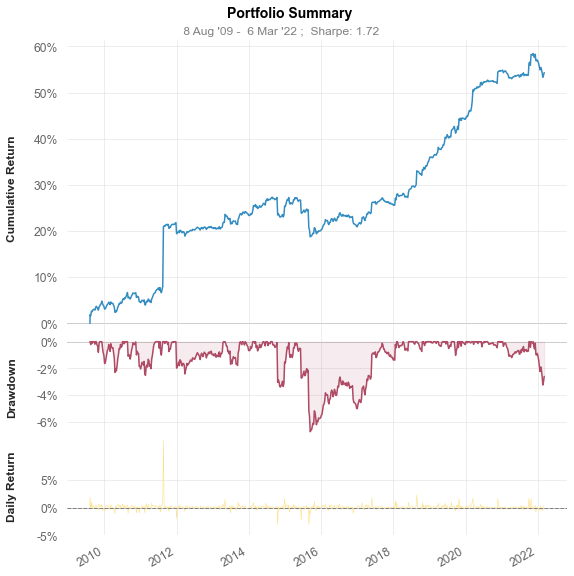

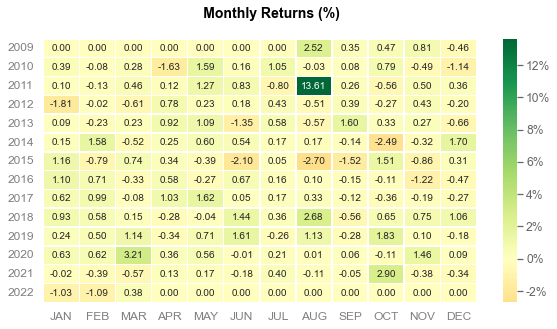

In [24]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

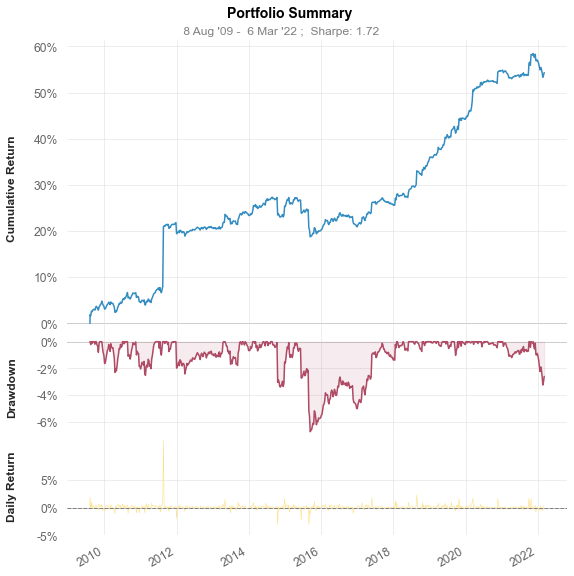

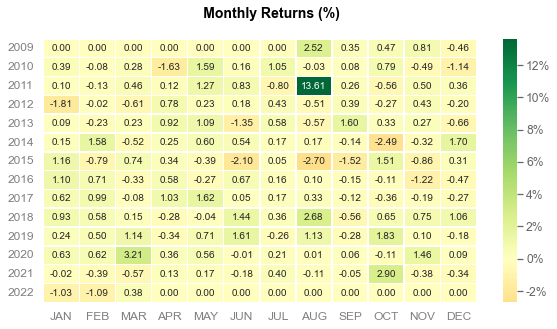

In [25]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-08-09  2009-08-09
End Period                 2022-03-06  2022-03-06
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          54.35%      172.42%
CAGR﹪                     3.51%       8.29%

Sharpe                     1.72        2.61
Smart Sharpe               1.68        2.55
Sortino                    3.84        3.86
Smart Sortino              3.76        3.78
Sortino/√2                 2.72        2.73
Smart Sortino/√2           2.66        2.67
Omega                      1.66        1.66

Max Drawdown               -6.76%      -9.11%
Longest DD Days            1253        483
Volatility (ann.)          9.95%       15.21%
R^2                        0.0         0.0
Calmar                     0.52        0.91
Skew                       10.33       -0.67
Kurtosis                   203.23      7.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2014-08-31,2015-09-13,2018-02-04,1253,-6.758875,-6.603330
2,2021-11-21,2022-02-20,2022-03-06,105,-3.252263,-2.974271
3,2010-08-29,2011-02-20,2011-06-05,280,-2.532845,-2.377121
4,2012-01-01,2012-03-25,2013-04-21,476,-2.423381,-2.123082
5,2009-12-13,2010-04-18,2010-07-04,203,-2.306309,-2.193264


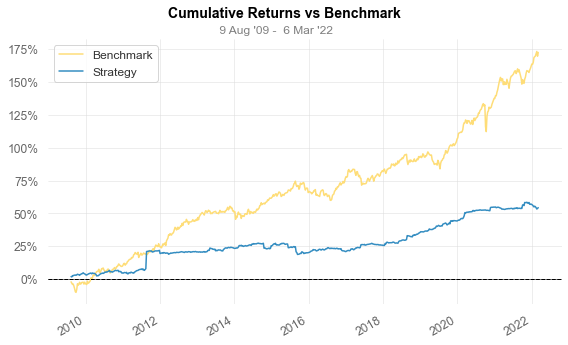

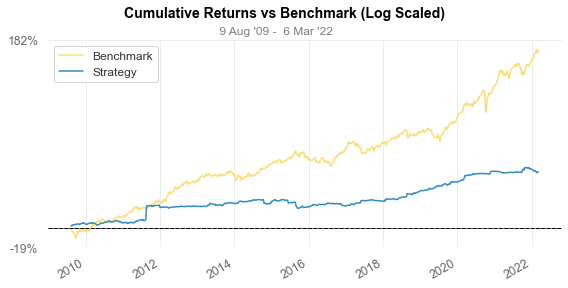

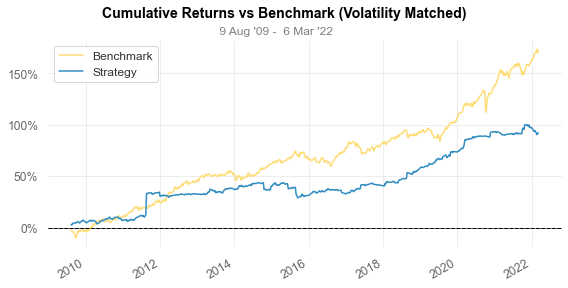

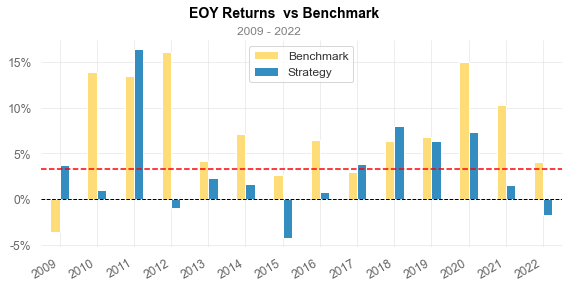

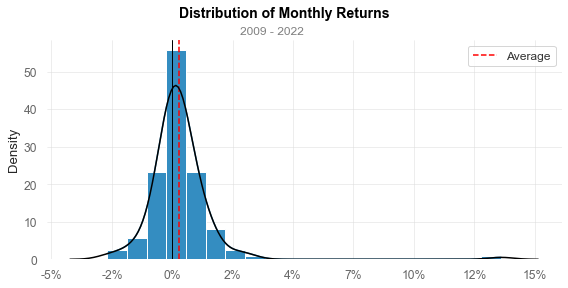

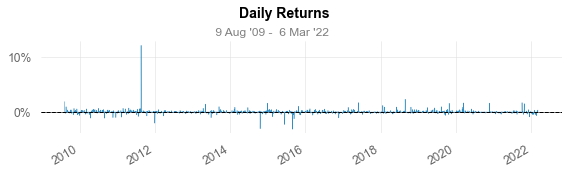

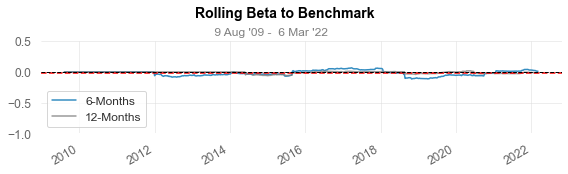

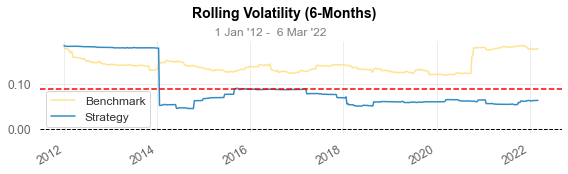

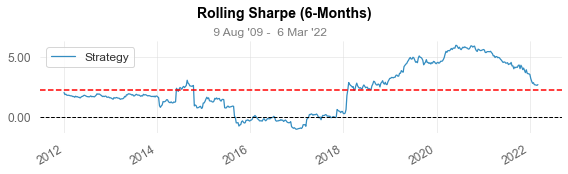

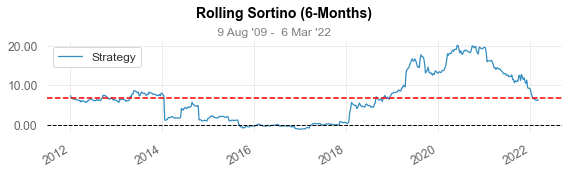

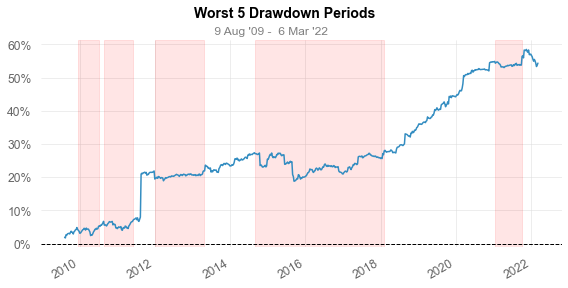

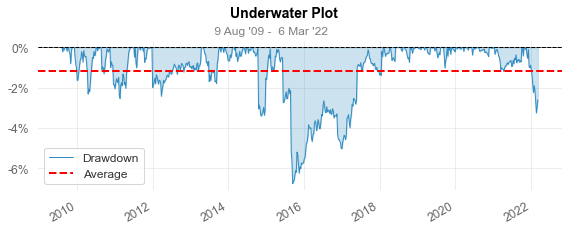

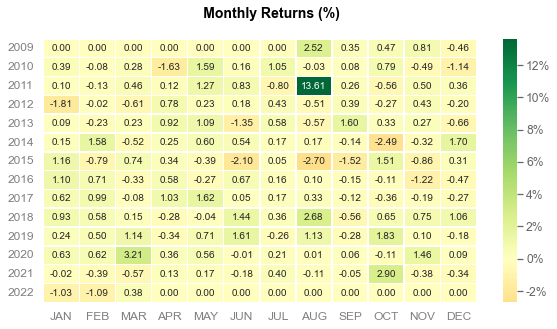

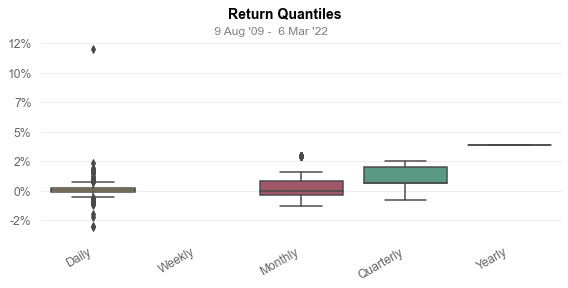

In [26]:
quantstats.reports.full(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'],)

In [27]:
canaria = yield_df[['IVV','VWO','BND']]
canaria.corr()

,IVV,VWO,BND
IVV,1.00000,0.812310,-0.081880
VWO,0.81231,1.000000,-0.062309
BND,-0.08188,-0.062309,1.000000


In [28]:
canaria_em = yield_df[['VWO','IVV']]
canaria_em.corr()

,VWO,IVV
VWO,1.00000,0.81231
IVV,0.81231,1.00000


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2008-08-10  2008-08-10
End Period                 2022-03-06  2022-03-06
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          56.1%       362.52%
CAGR﹪                     3.33%       11.94%

Sharpe                     0.57        1.48
Smart Sharpe               0.5         1.32
Sortino                    0.81        2.15
Smart Sortino              0.72        1.91
Sortino/√2                 0.57        1.52
Smart Sortino/√2           0.51        1.35
Omega                      1.11        1.11

Max Drawdown               -54.16%     -47.2%
Longest DD Days            2275        847
Volatility (ann.)          57.91%      43.01%
R^2                        0.66        0.66
Calmar                     0.06        0.25
Skew                       -0.06       -0.12
Kurtosis                   10.08       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-08-17,2008-11-02,2009-10-25,434,-54.160861,-51.709961
2,2018-02-11,2020-03-29,2020-11-15,1008,-35.378284,-29.162201
3,2011-05-15,2016-01-31,2017-08-06,2275,-34.355155,-31.533423
4,2010-04-18,2010-06-13,2010-09-19,154,-15.370529,-15.072251
5,2010-01-24,2010-02-14,2010-04-11,77,-13.801168,-7.999969


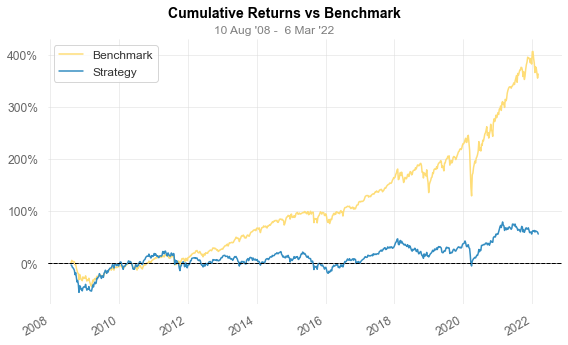

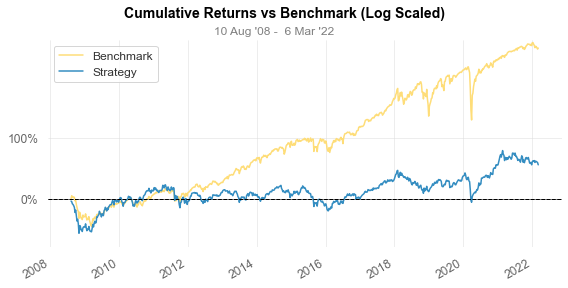

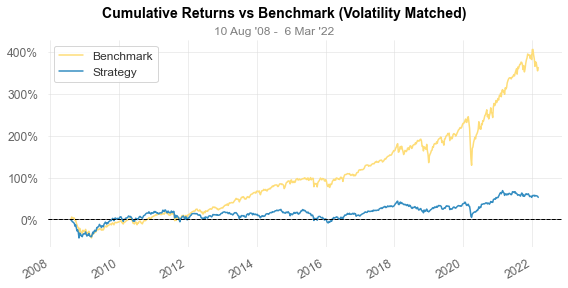

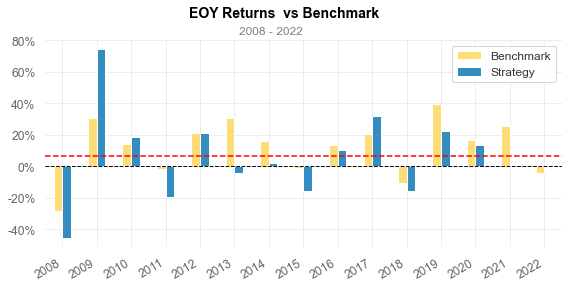

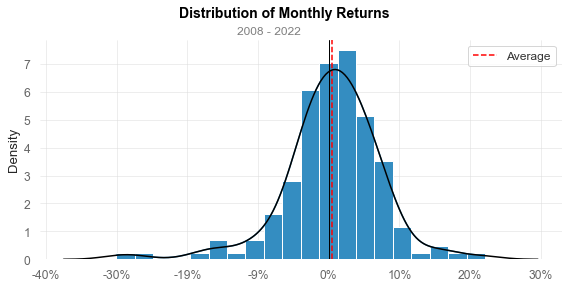

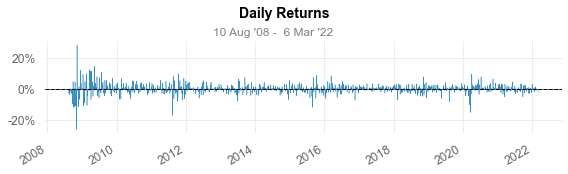

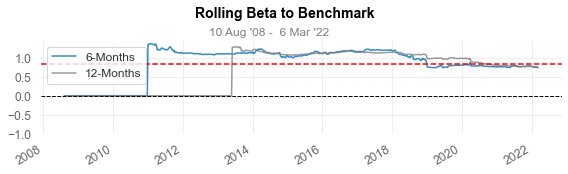

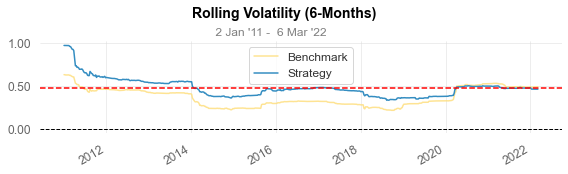

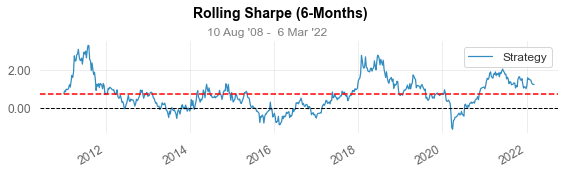

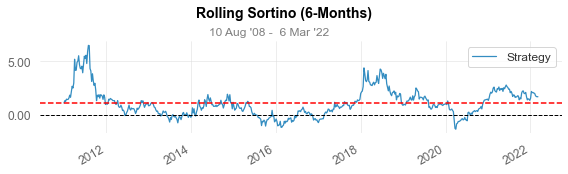

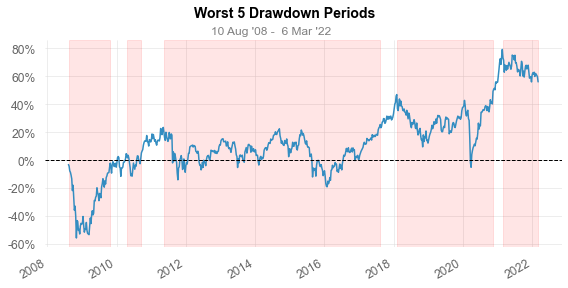

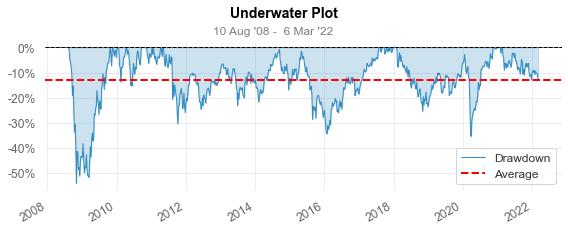

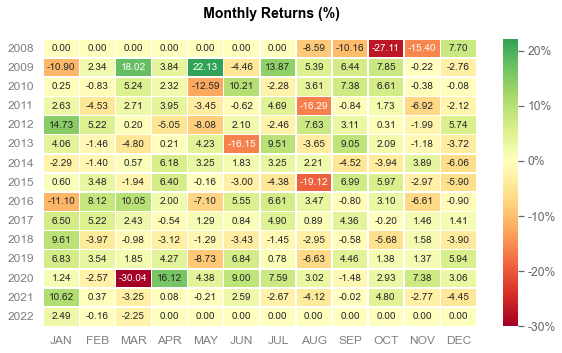

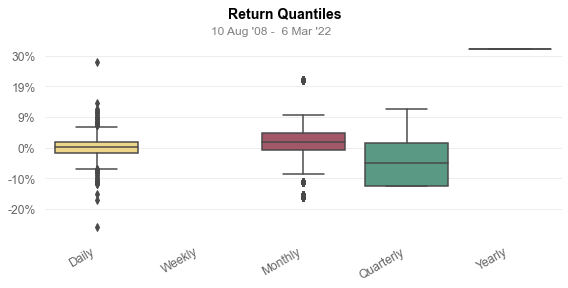

In [29]:
quantstats.reports.full(returns = canaria_em.loc[ : , 'VWO'],benchmark = canaria_em.loc[ :, 'IVV'],)

In [30]:
win_rate = len(canaria_em[canaria_em['VWO'] - canaria_em['IVV'] >= 0])
same_direction = len(canaria_em[canaria_em['VWO'] * canaria_em['IVV'] >= 0])
print("win rate of em is : ", win_rate/len(canaria_em), " same direction rate is : ", same_direction/len(canaria_em))

win rate of em is :  0.47390691114245415  same direction rate is :  0.7503526093088858


In [31]:
canaria_bnd = yield_df[['BND','IVV']]
canaria_bnd.corr()

,BND,IVV
BND,1.00000,-0.08188
IVV,-0.08188,1.00000


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2008-08-10  2008-08-10
End Period                 2022-03-06  2022-03-06
Risk-Free Rate             0.0%        0.0%
Time in Market             99.0%       100.0%

Cumulative Return          61.46%      362.52%
CAGR﹪                     3.59%       11.94%

Sharpe                     2.08        1.48
Smart Sharpe               1.97        1.41
Sortino                    3.01        2.15
Smart Sortino              2.85        2.04
Sortino/√2                 2.13        1.52
Smart Sortino/√2           2.02        1.44
Omega                      1.45        1.45

Max Drawdown               -5.94%      -47.2%
Longest DD Days            588         847
Volatility (ann.)          8.37%       43.01%
R^2                        0.01        0.01
Calmar                     0.6         0.25
Skew                       -0.8        -0.12
Kurtosis                   7.83        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-08-23,2022-02-20,2022-03-06,560,-5.942920,-5.699867
2,2008-09-28,2008-10-19,2008-12-21,84,-5.540984,-4.465097
3,2012-10-14,2013-06-30,2014-05-25,588,-4.596022,-4.549386
4,2020-03-22,2020-03-29,2020-05-31,70,-4.306721,-3.611734
5,2016-07-17,2016-12-25,2017-08-20,399,-4.158080,-4.092744


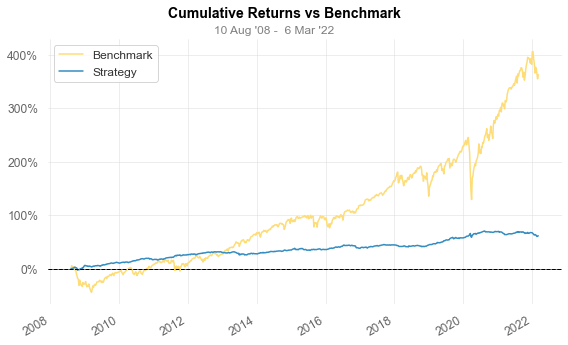

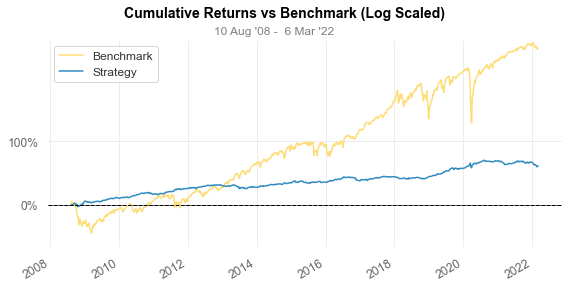

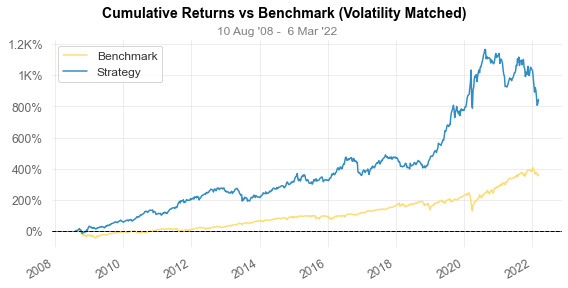

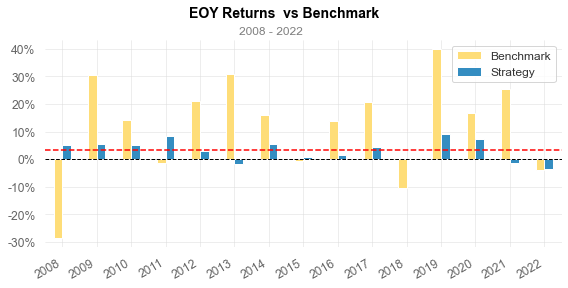

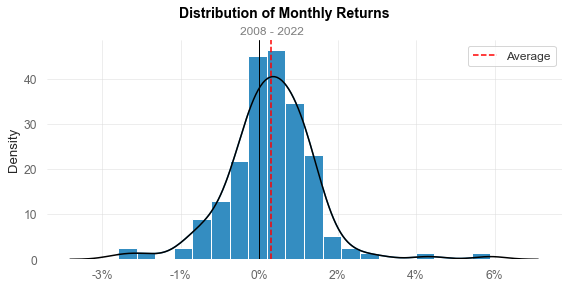

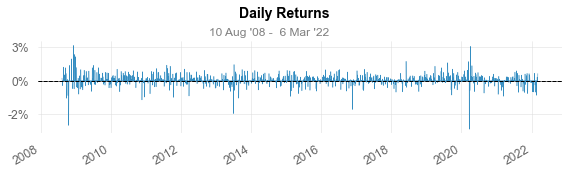

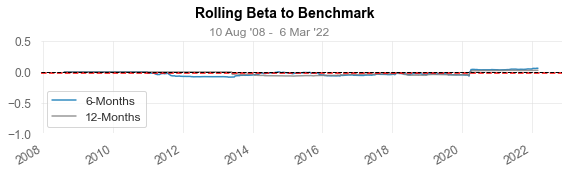

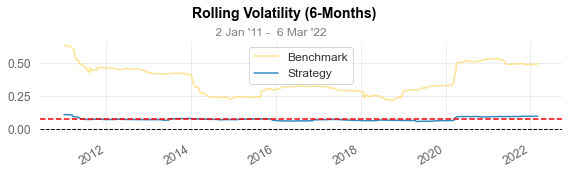

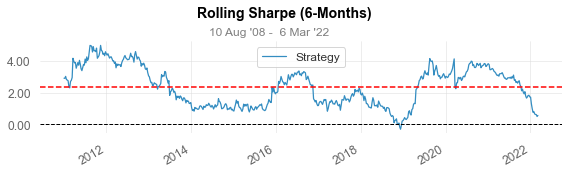

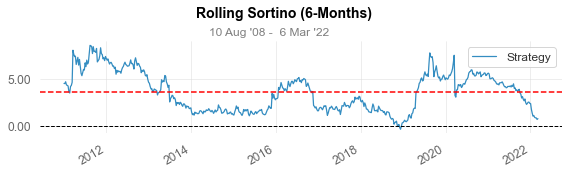

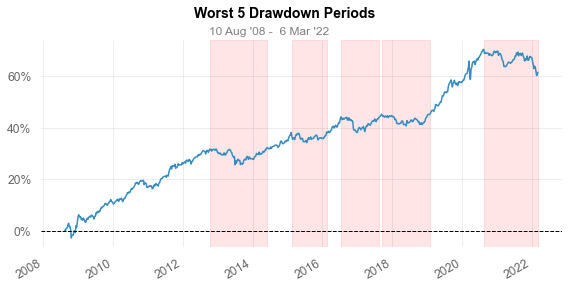

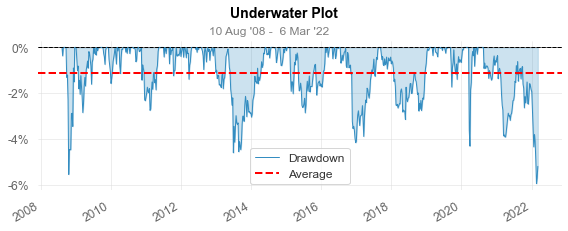

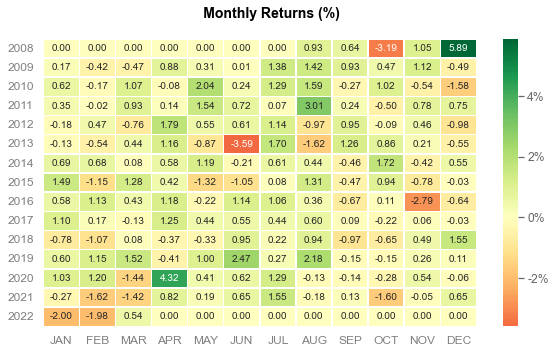

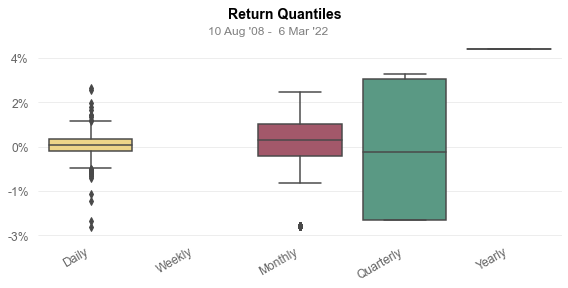

In [32]:
quantstats.reports.full(returns = canaria_bnd.loc[ : , 'BND'],benchmark = canaria_bnd.loc[ :, 'IVV'],)

In [33]:
win_rate = len(canaria_bnd[canaria_bnd['BND'] - canaria_bnd['IVV'] >= 0])
same_direction = len(canaria_bnd[canaria_bnd['BND'] * canaria_bnd['IVV'] >= 0])
print("win rate of em is : ", win_rate/len(canaria_bnd), " same direction rate is : ", same_direction/len(canaria_bnd))

win rate of em is :  0.4104372355430183  same direction rate is :  0.44710860366713684


## Why this strategy always escape from market
#### --------------------                 Win Rate %
#### Emerging Market        58.28%
#### Total Bond Market      63.8%
#### S&P500                 68.87%

#### canaria option acts if any canaria condition satisfied.
underperformance of emerging market triggered canaria
further underperformance can be found in underperformance of emerging market relative to developed market
if canaria condition triggers, the strategy escape from market, meaning that huge opportunity cost from rising developed market